<a href="https://colab.research.google.com/github/AzlinRusnan/Iris-PySpark-Analysis/blob/main/Iris_PySpark_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=fbc3dfa2f70de045dac974ce4dd87801b44693f944d211bba36df348e5bf17b3
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
# Initialize Spark session
spark = SparkSession.builder.appName("Iris Classification").getOrCreate()

In [7]:
# Load the Iris dataset from the uploaded file
iris_data = spark.read.csv("/content/gdrive/MyDrive/Data Management/iris.csv", header=True, inferSchema=True)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


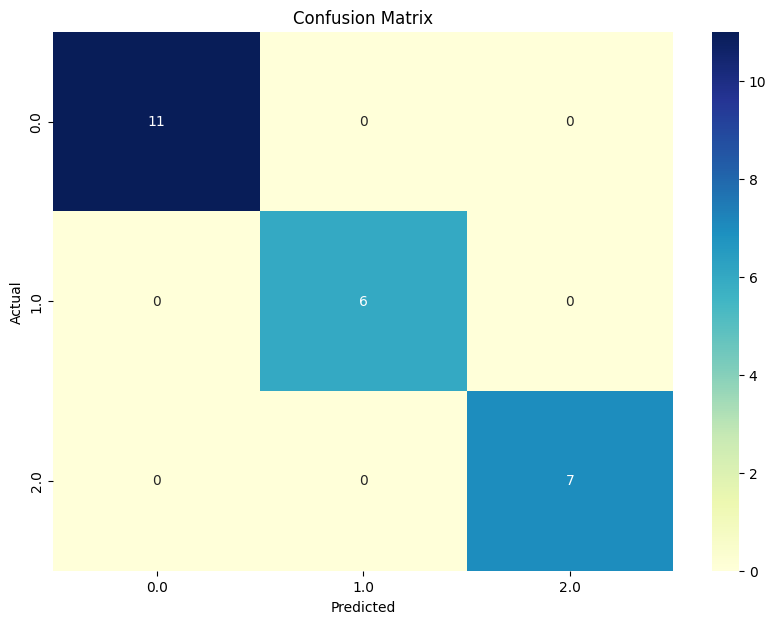

In [9]:
# Rename columns to match feature names
iris_data = iris_data.withColumnRenamed("Sepal.Length", "sepalLength")\
                     .withColumnRenamed("Sepal.Width", "sepalWidth")\
                     .withColumnRenamed("Petal.Length", "petalLength")\
                     .withColumnRenamed("Petal.Width", "petalWidth")\
                     .withColumnRenamed("Species", "label")

# Index labels (convert string labels to numeric)
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
iris_data = indexer.fit(iris_data).transform(iris_data)

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=["sepalLength", "sepalWidth", "petalLength", "petalWidth"], outputCol="features")
iris_data = assembler.transform(iris_data)

# Split the dataset into training and testing sets
train_data, test_data = iris_data.randomSplit([0.8, 0.2], seed=42)

# Select a classification algorithm: Random Forest
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Define a grid of hyperparameters to search over
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10, 20, 30])\
    .addGrid(rf.maxDepth, [5, 10, 15])\
    .build()

# Use cross-validation to tune hyperparameters
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy"),
                          numFolds=5)

# Fit the model on the training data
cv_model = crossval.fit(train_data)

# Evaluate the model on the test data
predictions = cv_model.transform(test_data)

# Evaluate the performance of the model
evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-Score: {}".format(f1))

# Collect predictions to a pandas DataFrame for visualization
preds_df = predictions.select("indexedLabel", "prediction").toPandas()

# Confusion Matrix
conf_matrix = pd.crosstab(preds_df['indexedLabel'], preds_df['prediction'], rownames=['Actual'], colnames=['Predicted'])

# Heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.show()

# Stop the Spark context
sc.stop()